# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [2]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`.

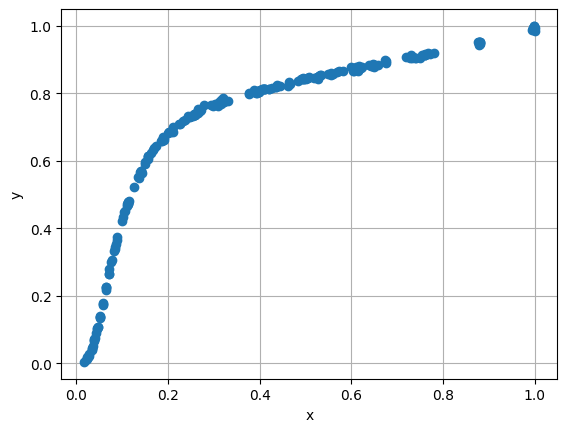

In [3]:
# TODO
x0 = np.array(df["x0"])
y0 = np.array(df["y0"])
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

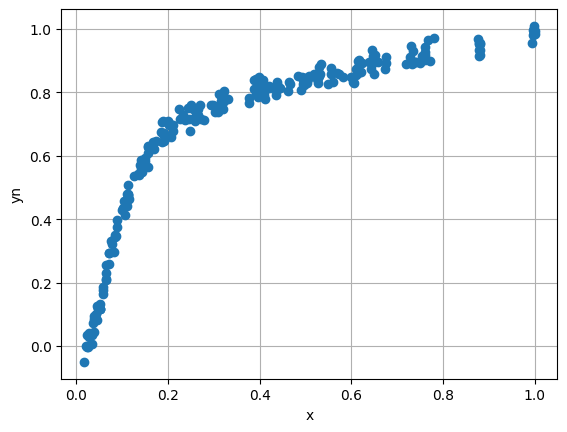

In [4]:
# TODO
mu, sigma = 0, 0.02 # mean and standard deviation
noise = np.random.normal(mu, sigma, y.size)
yn = y + noise
plt.plot(x,yn, 'o')
plt.xlabel('x')
plt.ylabel('yn')
plt.grid(True)
plt.show()

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [5]:
from sklearn.model_selection import train_test_split

# TODO
xtr, xts, ytr, yts = train_test_split(x,yn,test_size=0.33, random_state=42)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [6]:
def predict(w, x):
    # Determine polynomial degree from the length of w
    d = (len(w) - 1) // 2

    # Extract a and b from w
    a = w[0:d+1]           # First d+1 elements for a
    b = w[d+1:]           # Remaining d elements for b
    # Compute yhat
    num = np.polyval(a[::-1], x)             # Evaluate numerator polynomial
    denom = (1 + np.abs(np.polyval(b[::-1], x)))

    yhat = num / denom

    return yhat






When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ]

In [7]:
d = 3
# TODO.  Create the transformed feature matrix
y = np.array(y)

powers = np.arange(1, d + 1)
x_powers = np.array([x**p for p in powers]).T
y_powers = y[:, np.newaxis] * x_powers
Z = np.column_stack((x_powers, y_powers))



Ztr, Zts = train_test_split(Z, test_size=0.33, random_state=42)

# TODO.  Fit with parameters with linear regression
regr = LinearRegression()
regr.fit(Ztr, ytr)

# TODO
# Extract the parameters from regr.coef_ and regr.intercept_ and store the parameter vector in winit
winit = np.append([regr.intercept_ ], regr.coef_ )
print(winit)









[ -0.31428143  12.71721461 -46.66198598  37.55279895  -6.35429211
  38.18650724 -34.16973129]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

-0.03819256887775701


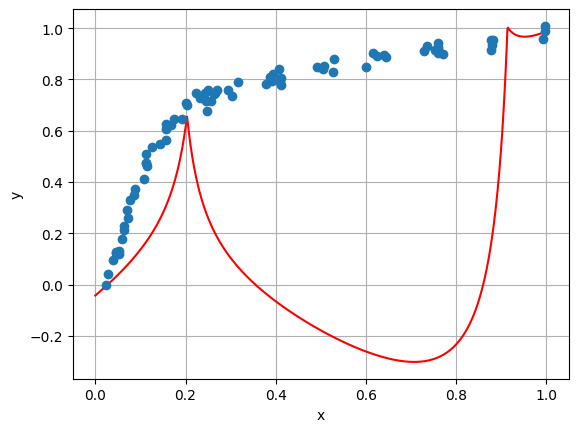

In [8]:
# TODO
xp = np.linspace(0, 1, 1000)
yhat = predict(winit,xp)
print(yhat[3])

plt.plot(xp, yhat, 'r')
plt.plot(xts, yts, 'o')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()




The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

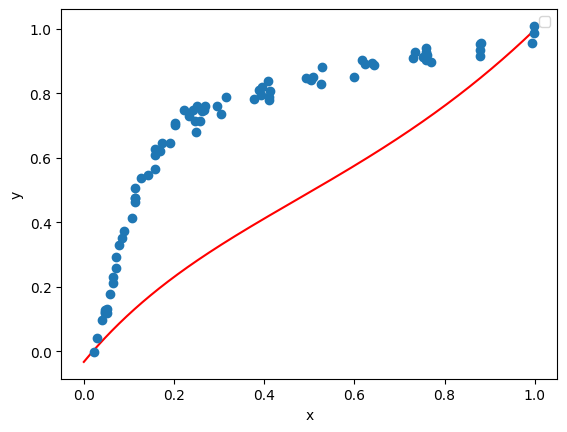

In [9]:
# TODO.  Fit with parameters with linear regression
d =3

regr = Ridge(alpha=1e-3)
regr.fit(Ztr, ytr)
# TODO
# Extract the parameters from regr.coef_ and regr.intercept_
winit = np.append( regr.intercept_, regr.coef_ )

# TODO
# Plot the results as above.

xp = np.linspace(0,1, 1000)



yhat_2 = predict(winit,xp)

plt.plot(xp, yhat_2, 'r')
plt.plot(xts, yts, 'o')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()








## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [10]:
def feval(w, x, y):

    # Parse w into coefficients a and b
    a = w[:d + 1]
    b = w[d + 1:]

    # TODO.  Znum[i,j] = x[i]**j
    Znum = np.array([x ** j for j in range(d + 1)]).T

    # TODO.  Zden[i,j] = x[i]**(j+1)
    Zden = np.array([x ** (j + 1) for j in range(d)]).T

  # TODO.  Compute yhat
    # Compute the numerator and denominator
    num = Znum @ a
    denom = 1 + Zden @ b
    yhat = num / denom

    # TODO.  Compute loss
    # f = ...
    residuals = y - yhat
    f = 0.5 * np.sum(residuals ** 2)

    # TODO.  Compute gradients
    # fgrad = ...
    grad_a = -np.sum((residuals / denom)[:, np.newaxis] * Znum, axis=0)

    # Gradients with respect to `b`
    grad_b = np.sum((residuals * yhat / denom)[:, np.newaxis] * Zden, axis=0)

    # Combine gradients into a single vector
    fgrad = np.concatenate([grad_a, grad_b])

    return f, fgrad

Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [11]:
# TODO
w0 = winit.copy()
f0,fgrad0 = feval(w0,xtr,ytr)
w1 = winit + 0.00001
f1,fgrad1 = feval(w1,xtr,ytr)


predicted_change =np.dot(fgrad0, w1 - w0)
actual_change = f1-f0

print("Gradient check: actual change =", actual_change, " predicted change =", predicted_change)

Gradient check: actual change = 0.7133060387668593  predicted change = 0.7131281332898236


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

Text(0.5, 1.0, 'Gradient Descent Convergence')

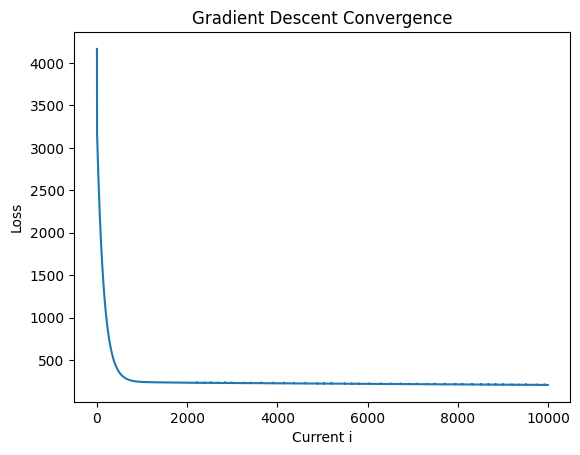

In [12]:
# TODO
# fgd = ...
nit = 10000
step = 1e-6
w = winit.copy()
fgd = []
for  i in range(nit):
  f_i,fgrad_i = feval(w,xtr,ytr)
  w-=step*fgrad_i
  fgd.append(f_i)



plt.plot(fgd)
plt.xlabel("Current i")
plt.ylabel("Loss")
plt.title("Gradient Descent Convergence")





Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

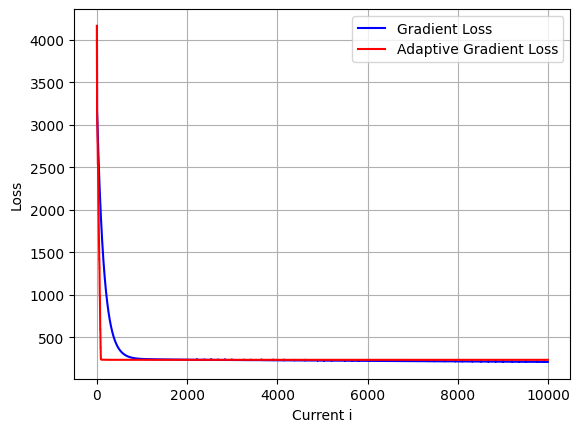

In [13]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6  # Initial step
w = winit.copy()
fadapt = []

f0, fgrad0 = feval(w, xtr, ytr)

for it in range(nit):

    w1 = w - step * fgrad0

    f1, fgrad1 = feval(w1, xtr, ytr)
    df_est = fgrad0.dot(w1 - w)
    alpha = 0.5
    if (f1 - f0 < alpha * df_est) and (f1 < f0):
        step *= 2
        f0 = f1
        fgrad0 = fgrad1
        w = w1
    else:
        step /= 2

    fadapt.append(f0)

plt.plot(fgd, label='Gradient Loss', color='blue')
plt.plot(fadapt, label='Adaptive Gradient Loss', color='red')
plt.xlabel('Current i')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

Text(0, 0.5, 'y')

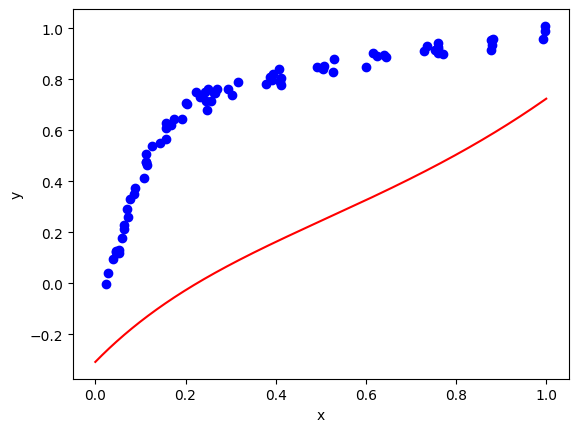

In [14]:
# TODO
xp = np.linspace(0,1, 1000)
yhat = predict(w, xp)
plt.plot(xp, yhat, color='red')
plt.scatter(xts, yts, color='blue')
plt.xlabel("x")
plt.ylabel("y")


## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

In [15]:
# TODO
nit = 1000
step = 1e-3
beta = 0.99

In [16]:
# TODO
# plot yhat vs. x

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.